In [4]:
# System packages
import os
import sys
import warnings
# Data related
import numpy as np 
import pandas as pd 

# sklearn tools 
from sklearn.metrics import  accuracy_score
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

# sklearn models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
import xgboost as xgb

In [5]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
# Import custom functions
from utils_functions import *

Using TensorFlow backend.


## 1. Load full data

In [4]:
df = pd.read_csv('../data/processed/train_variants_text.csv')


### Use a sample data

In [111]:
'''
sample =df.groupby('Class').apply(lambda x: x.sample(frac=0.2))
sample =sample.drop([sample.columns[1], 
                     sample.columns[2], 
                     sample.columns[5]], 
                    axis='columns')
sample.dropna(subset=['Text'])
sample.head(1)
sample.to_csv('../data/processed/train_variants_text_sample.csv')
'''

In [6]:
sample = pd.read_csv('../data/processed/train_variants_text_sample.csv')

In [7]:
sample.head()

,Class,Gene,Variation,Text
0,1,NF2,L46R,Neurofibromatosis type 2 (NF2) is a multiple n...
1,1,FGFR2,E219K,Introduction Melanoma is the most lethal of a...
2,1,BRCA1,F1704S,Abstract The BRCA1 gene from individuals at ...
3,1,TP53,R337H,The tumor suppressor protein p53 is a transcri...
4,1,TSC2,E75G,Tuberous sclerosis complex (TSC) is an autosom...


### Split sample data into train and validation data set

In [263]:
X_tr, X_val, y_tr, y_val = split_data(sample,
                                      'Text',
                                      'Class',
                                      0.1,
                                      0,
                                      stratify='Class')

In [7]:
# Take a look at the first y_tr and X_tr
#print(y_tr[0], "-is the predicted Class for text -", X_tr[0],)

## 2. Feature extraction

### 2.1 Bag of words
Here we will use 
 * CountVectorizer: Counts the number of times a word appears in the text
 * TfidfVectorizer: Weighs the words according to the importance of the word in the context of whole collection
 

### 2.2 Word2Vec

In [39]:
# Use document df
w2vec = get_word2vec(
    MySentences(
        sample['Text'].values, 
    ),
    'w2vmodel'
)

Found w2vmodel


## 3. Training

## 3.1 Bag of words + Model

### 3.1.1 Naive Bayes classifier for multinomial models
Suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [9]:
clf = Pipeline([('vect', CountVectorizer(preprocessor=clean_text_stemmed, stop_words =stop_words)),
                         ('tfidf', TfidfTransformer()),
                         ('clf',  MultinomialNB())])                           

In [10]:
clf.fit(X_tr, y_tr)  
predicted = clf.predict(X_val)
acc=np.mean(predicted == y_val)
print(acc)
#print(classification_report(y_val, predicted))

0.44776119402985076


### 3.1.2 SGD 

This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). SGD allows minibatch (online/out-of-core) learning, see the partial_fit method. For best results using the default learning rate schedule, the data should have zero mean and unit variance.

In [16]:
clf = Pipeline([('vect', CountVectorizer(preprocessor=clean_text_stemmed, stop_words =stop_words)),
                ('tfidf', TfidfTransformer()),
                ('clf',  SGDClassifier(n_jobs=))])                           

In [17]:
clf.fit(X_tr, y_tr)  
predicted = clf.predict(X_val)
acc=np.mean(predicted == y_val)
print(acc)

0.4925373134328358


### 3.1.3 TfidfTransformer + xgboost

In [261]:
# Without text cleaning
clf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf',  xgb.XGBClassifier(objective="multi:softprob", random_state=42))])                           

In [264]:
clf.fit(X_tr, y_tr)  
predicted = clf.predict(X_val)
acc=np.mean(predicted == y_val)
print(acc)

0.5223880597014925


In [28]:
# With text cleaning
clf = Pipeline([('vect', CountVectorizer(preprocessor=clean_text_stemmed, stop_words =stop_words)),
                ('tfidf', TfidfTransformer()),
                ('clf',  xgb.XGBClassifier(objective="multi:softprob", random_state=42))])                           

In [29]:
clf.fit(X_tr, y_tr)  
predicted = clf.predict(X_val)
acc=np.mean(predicted == y_val)
print(acc)

0.5671641791044776


### 3.1.4 DictVectorizer(Gene) +  DictVectorizer(Variation) + xgboost

In [9]:
sample['Class'] = sample['Class'].astype(int)
sample['Gene'] = sample['Gene'].astype(str)
sample['Variation'] = sample['Variation'].astype(str)

y= sample['Class']
X= sample.drop('Class',axis =1)
X_tr, X_val, y_tr, y_val = train_test_split(X,
                                            y,
                                            test_size=0.2,
                                            stratify=y,
                                            random_state=42)

In [177]:
processing_pipeline= make_pipeline(
    # combine features
    make_union(
        make_pipeline(
            PandasSelector(["Gene","Variation"]),
            PandasToDict(),
            DictVectorizer(sparse=False)
            # select categorical data
        )
    
    )
)


In [178]:
clf =xgb.XGBClassifier(objective="multi:softprob", random_state=42)

In [179]:
model = make_pipeline(processing_pipeline, clf)

In [181]:
model.fit(X_tr, y_tr)

Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('pipeline', Pipeline(memory=None,
     steps=[('pandasselector', PandasSelector(columns=['Gene', 'Variation'])), ('pandastodict', PandasToDict()), ('dictvectorizer', DictVectori...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [182]:
predicted = model.predict(X_val)

acc=np.mean(predicted == y_val)
print(acc)

0.42105263157894735


### 3.1.5 TFIDF(Text) + xgboost

In [251]:
processing_pipeline= make_pipeline(
    # combine features
    make_union(
        
        make_pipeline(
            ItemSelector(key='Text'),
            Converter(),
            TfidfVectorizer()
                    )
)
)

In [252]:
clf =xgb.XGBClassifier(objective="multi:softprob", random_state=42)
model = make_pipeline(processing_pipeline, clf)
model.fit(X_tr, y_tr)

Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('pipeline', Pipeline(memory=None,
     steps=[('itemselector', ItemSelector(key='Text')), ('converter', Converter()), ('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [253]:
predicted = model.predict(X_val)

acc=np.mean(predicted == y_val)
print(acc)

0.631578947368421


### 3.1.6 OneHot(Gene) + TFIDF(Text)  + xgboost

In [235]:
processing_pipeline= make_pipeline(
    # combine features
    make_union(
        
        make_pipeline(
            ItemSelector(key='Text'),
            Converter(),
            TfidfVectorizer()
                    ),    
        make_pipeline(
            ItemSelector(key="Gene"),
            Converter(),
            OneHotEncoder()
    )
)
)

In [236]:
model = make_pipeline(processing_pipeline, clf)
model.fit(X_tr, y_tr)

Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('pipeline-1', Pipeline(memory=None,
     steps=[('itemselector', ItemSelector(key='Text')), ('converter', Converter()), ('tfidfvectorizer', TfidfVectorizer(analyzer='word', bina...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [237]:
predicted = model.predict(X_val)

acc=np.mean(predicted == y_val)
print(acc)

0.6240601503759399


### 3.1.7 OneHot(Variation) + TFIDF(Text) + xgboost

In [247]:
processing_pipeline= make_pipeline(
    # combine features
    make_union(    
        make_pipeline(
            ItemSelector(key='Text'),
            Converter(),
            TfidfVectorizer()
                    ),
        make_pipeline(
            ItemSelector(key="Variation"),
            Converter(),
            OneHotEncoder()
    )
)
)

In [248]:
model = make_pipeline(processing_pipeline, clf)
model.fit(X_tr, y_tr)

Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('pipeline-1', Pipeline(memory=None,
     steps=[('itemselector', ItemSelector(key='Text')), ('converter', Converter()), ('tfidfvectorizer', TfidfVectorizer(analyzer='word', bina...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [249]:
predicted = model.predict(X_val)

acc=np.mean(predicted == y_val)
print(acc)

0.631578947368421


In [254]:
def model_predict(processing_pipeline,clf,X_tr,y_tr,X_val,y_val):
    model = make_pipeline(processing_pipeline, clf)
    model.fit(X_tr, y_tr)
    predicted = model.predict(X_val)
    acc=np.mean(predicted == y_val)
    print(acc)

In [ ]:
model_predict(processing_pipeline,clf,X_tr,y_tr,X_val,y_val)

### 3.1.8 OneHot(Variation) + OneHot(Gene) + TFIDF(Text)  + xgboost


In [241]:
processing_pipeline2= make_pipeline(
    # combine features
    make_union(
        
        make_pipeline(
            ItemSelector(key='Text'),
            Converter(),
            TfidfVectorizer()
                    ),    
        make_pipeline(
            ItemSelector(key="Gene"),
            Converter(),
            OneHotEncoder()
        ),
        make_pipeline(
            ItemSelector(key="Variation"),
            Converter(),
            OneHotEncoder()
    )
)
)

In [242]:
model2 = make_pipeline(processing_pipeline2, clf)
model2.fit(X_tr, y_tr)

Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('pipeline-1', Pipeline(memory=None,
     steps=[('itemselector', ItemSelector(key='Text')), ('converter', Converter()), ('tfidfvectorizer', TfidfVectorizer(analyzer='word', bina...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [243]:
predicted2 = model2.predict(X_val)

acc2=np.mean(predicted2 == y_val)
print(acc2)

0.6240601503759399


### 3.1.9 TFIDF(Gene) + TFIDF(Text)  + xgboost

In [13]:
processing_pipeline= make_pipeline(
    # combine features
    make_union(  
        make_pipeline(
            ItemSelector(key="Gene"),
            Converter(),
            TfidfVectorizer()
    )
)
)

In [14]:
clf =xgb.XGBClassifier(objective="multi:softprob", random_state=42)
model = make_pipeline(processing_pipeline, clf)
model.fit(X_tr, y_tr)

Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('pipeline', Pipeline(memory=None,
     steps=[('itemselector', ItemSelector(key='Gene')), ('converter', Converter()), ('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [15]:
predicted = model.predict(X_val)

acc=np.mean(predicted == y_val)
print(acc)

0.3458646616541353


### 3.1.10 TFIDF(Variation) +  TFIDF(Gene) +xgboost

In [23]:
processing_pipeline= make_pipeline(
    # combine features
    make_union(  
        make_pipeline(
            ItemSelector(key="Variation"),
            Converter(),
            TfidfVectorizer()
        ),
        make_pipeline(
            ItemSelector(key="Gene"),
            Converter(),
            TfidfVectorizer()
    )
   
    )
)


In [24]:
clf =xgb.XGBClassifier(objective="multi:softprob", random_state=42)
model = make_pipeline(processing_pipeline, clf)
model.fit(X_tr, y_tr)


Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('pipeline-1', Pipeline(memory=None,
     steps=[('itemselector', ItemSelector(key='Variation')), ('converter', Converter()), ('tfidfvectorizer', TfidfVectorizer(analyzer='word',...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [25]:
# prediction
predicted = model.predict(X_val)
acc=np.mean(predicted == y_val)
print(acc)

0.41353383458646614


In [19]:
print(sample.Gene.nunique())
print(sample.Variation.nunique())

150
617


### 3.1.11 TFIDF(Gene) + TFIDF(Text)  + xgboost

In [8]:
processing_pipeline= make_pipeline(
    # combine features
    make_union(
        
        make_pipeline(
            ItemSelector(key='Text'),
            Converter(),
            TfidfVectorizer()
                    ),    
        make_pipeline(
            ItemSelector(key="Gene"),
            Converter(),
            TfidfVectorizer()
    )
)
)

In [11]:
clf =xgb.XGBClassifier(objective="multi:softprob", random_state=42)
model = make_pipeline(processing_pipeline, clf)
model.fit(X_tr, y_tr)

Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('pipeline-1', Pipeline(memory=None,
     steps=[('itemselector', ItemSelector(key='Text')), ('converter', Converter()), ('tfidfvectorizer', TfidfVectorizer(analyzer='word', bina...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [12]:
predicted = model.predict(X_val)

acc=np.mean(predicted == y_val)
print(acc)

0.6240601503759399


### 3.1.11 make_pipeline + make_unionn & TFIDF(Variation) + TFIDF(Gene) + TFIDF(Text) + xgboost

In [26]:
processing_pipeline= make_pipeline(
    # combine features
    make_union(  
        make_pipeline(
            ItemSelector(key="Variation"),
            Converter(),
            TfidfVectorizer()
        ),
        make_pipeline(
            ItemSelector(key="Gene"),
            Converter(),
            TfidfVectorizer()
    ),
        make_pipeline(
            ItemSelector(key='Text'),
            Converter(),
            TfidfVectorizer()
        )
   
    )
)


In [27]:
clf =xgb.XGBClassifier(objective="multi:softprob", random_state=42)
model = make_pipeline(processing_pipeline, clf)
model.fit(X_tr, y_tr)


Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('pipeline-1', Pipeline(memory=None,
     steps=[('itemselector', ItemSelector(key='Variation')), ('converter', Converter()), ('tfidfvectorizer', TfidfVectorizer(analyzer='word',...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [28]:
# prediction
predicted = model.predict(X_val)
acc=np.mean(predicted == y_val)
print(acc)

0.6240601503759399


### 3.1.12 Pipeline + featureunion + explain _features & TFIDF(Variation) + TFIDF(Gene) + TFIDF(Text) + xgboost

In [53]:
Variation = Pipeline([
    ('selector',ItemSelector(key="Variation")),
    ('converter',Converter()),
    ('tfidf', TfidfVectorizer())
])

Gene = Pipeline([
    ('selector',ItemSelector(key="Gene")),
    ('converter',Converter()),
    ('tfidf', TfidfVectorizer())
])

Text = Pipeline([
    ('selector',ItemSelector(key="Text")),
    ('converter',Converter()),
    ('tfidf', TfidfVectorizer())
    
])

ppl = Pipeline([
    ('features',FeatureUnion([
        ('Variation',Variation),
        ('Gene',Gene),
        ('Text',Text)
    ])),
    ('clf',xgb.XGBClassifier(objective="multi:softprob", random_state=42))
])

In [56]:
model = ppl.fit(X_tr,y_tr)

In [117]:
# Accuracy score 
model.score(X_val,y_val)

0.6240601503759399

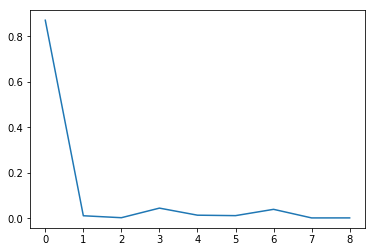

In [167]:
# Calculate predict probability for each class
y_pred = model.predict_proba(X_val)[0]
y_pred 

# plot the probability 
plt.plot(y_pred)


In [96]:
model.named_steps['features'].transformer_list

[('Variation', Pipeline(memory=None,
       steps=[('selector', ItemSelector(key='Variation')), ('converter', Converter()), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=None, min_df=1,
   ...
          token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
          vocabulary=None))])), ('Gene', Pipeline(memory=None,
       steps=[('selector', ItemSelector(key='Gene')), ('converter', Converter()), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ...
          token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
          vocabulary=None))])), ('Text', Pipeline(memory=None,
       steps=[('selector', ItemSelector(key='Text')),

In [97]:
f1=model.named_steps['features'].transformer_list[0][1].named_steps['tfidf'].get_feature_names()
f2=model.named_steps['features'].transformer_list[1][1].named_steps['tfidf'].get_feature_names()
f3=model.named_steps['features'].transformer_list[2][1].named_steps['tfidf'].get_feature_names()

In [98]:
list_features=f1
# Add all the elements of f2 and f3 to f1
list_features.extend(f2)
list_features.extend(f3)

In [172]:
#!pip install eli5
from eli5.explain import explain_weights
from eli5.formatters import explain_weights_df

explain_weights(model.named_steps['clf'], 
                 vec=None, top=10, 
                 target_names=ppl.classes_, 
                 feature_names=list_features)


Weight,Feature
0.0128,unclassified
0.0115,select
0.0099,mutagenized
0.0098,erk
0.0079,kras
0.0078,formation
0.0076,57
0.0073,partial
0.0069,25th
0.0069,calculate


In [107]:
# Save to csv

## Summary
1. Fill NA, define dtype 
2. Feature extraction and Union
3. Define model Pipeline
4. model = Pipeline.fit(X,y)
5. model.score(X_val,y_val)


In [205]:
sample['Class'] = sample['Class'].astype(int)
sample['Gene'] = sample['Gene'].astype(str)
sample['Variation'] = sample['Variation'].astype(str)

y= sample['Class']
X= sample.drop('Class',axis =1)
X_tr, X_val, y_tr, y_val = train_test_split(X,
                                            y,
                                            test_size=0.2,
                                            stratify=y,
                                            random_state=42)

In [175]:
# 2. Feature extraction and Union
default_preprocessor = CountVectorizer().build_preprocessor()
def build_preprocessor(df,field):
    field_idx = list(df.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])
    

In [213]:
# 2. Feature extraction and Union
vectorizer = FeatureUnion([
    ('Variation',TfidfVectorizer(preprocessor=build_preprocessor(X,'Variation'))),
        ('Gene',TfidfVectorizer(preprocessor=build_preprocessor(X,'Gene'))),
        ('Text',TfidfVectorizer(preprocessor=build_preprocessor(X,'Text'))),
])

In [214]:
X_v = vectorizer.fit_transform(X.values)


In [215]:
X_tr, X_val, y_tr, y_val = train_test_split(X_v,
                                            y,
                                            test_size=0.2,
                                            stratify=y,
                                            random_state=42)

In [216]:
model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
model.fit(X_tr, y_tr)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [217]:
# Accuracy score 
model.score(X_val,y_val)

0.6390977443609023

In [218]:
eli5.show_weights(model, vec=vectorizer)

Weight,Feature
0.0135,Text__formation
0.0091,Text__mutagenized
0.0078,Text__variant
0.0070,Text__25th
0.0069,Text__calculate
0.0067,Text__activated
0.0065,Text__kras
0.0065,Text__21
0.0062,Text__6b
0.0061,Text__treatment


In [221]:
eli5.show_weights(model, vec=vectorizer, top=10, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.0135,Text__formation
0.0091,Text__mutagenized
0.0078,Text__variant
0.0070,Text__25th
0.0069,Text__calculate
0.0067,Text__activated
0.0065,Text__kras
0.0065,Text__21
0.0062,Text__6b
0.0061,Text__treatment


In [227]:
df_name = explain_weights_df(model, vec=vectorizer, top=10, feature_filter=lambda x: x != '<BIAS>')
                
df_name.to_csv('../data/features/20190609sample_union_3groups_tfidf_feature_weights.csv')

In [226]:
# Analyzing individual predictions. Let's check some predictions from the validation set. You see a summary of various vectorizer's contribution at the top, and then below you can see features highlighed in text.
eli5.show_prediction(model, doc=X.values[1], vec=vectorizer)

## 3.2 Word2vec + Model

### 3.2.1 Document-trained w2vec + xgboost

In [40]:
clf = Pipeline([('vect', MeanEmbeddingVectorizer(w2vec)),
                ('clf',  xgb.XGBClassifier(objective="multi:softprob", random_state=42))])                           

In [41]:
clf.fit(X_tr, y_tr)  
predicted = clf.predict(X_val)
acc=np.mean(predicted == y_val)
print(acc)

0.4626865671641791


### Lessons learned

 * Text pre-processing helps 
 * W2vec: domain corpus helps 
 * A small document: w2vec may not outperform tfidf
 * One-hot encodings is not good for tree based methods 
 * Knowing what featurews are useful/useless for prediction is helpful 
